In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

## Small-scale experiments

### Initialize

#### Variables

In [4]:
SCALE = 'SmallScale'
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = 10

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20b']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [5]:
ARCHITECTURE = 'LeNet'   
sm_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [6]:
ARCHITECTURE = 'LeNet'          
eos_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg all)'},
]

#### Evaluation data from OvR

In [7]:
ARCHITECTURE = 'LeNet'   
ovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [8]:
ARCHITECTURE = 'LeNet'          
ovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OvR'], 'label': 'OvR-F (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OvR'], 'label': 'OvR-M (0)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-M (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-M (0.4)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-M (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OvR'], 'label': 'OvR-M (0.8)'}],
}

ovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-M'},
]

In [9]:
ARCHITECTURE = 'LeNet'
ovr_data_info_3_T = {
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg all)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg all)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OvR'], 'label': 'OvR-M (0 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-M (0.2 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OvR'], 'label': 'OvR-M (0.4 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-M (0.6 w/ neg all)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OvR'], 'label': 'OvR-M (0.8 w/ neg all)'}],
}

ovr_data_info_3_10k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_02', 'OvR'], 'label': 'OvR-M (w/ neg 10k)'},
]

ovr_data_info_3_20k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_02', 'OvR'], 'label': 'OvR-M (w/ neg 10k)'},
]

ovr_data_info_3_30k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_02', 'OvR'], 'label': 'OvR-M (w/ neg 10k)'},
]

ovr_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-M (w/ neg All)'},
]

In [10]:
ARCHITECTURE = 'LeNet_plus_plus'   
ovr_data_info_D = [
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C10_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=10, w/ neg)'},
]

#### Evaluation data from OSOvR

In [11]:
ARCHITECTURE = 'LeNet'
osovr_data_info_0_T = [
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_5', 'OpenSetOvR'], 'label': 'OSOvR (5)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_6', 'OpenSetOvR'], 'label': 'OSOvR (6)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_8', 'OpenSetOvR'], 'label': 'OSOvR (8)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_12', 'OpenSetOvR'], 'label': 'OSOvR (12)'},
]

In [12]:
ARCHITECTURE = 'LeNet'   
osovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
]

In [13]:
ARCHITECTURE = 'LeNet'          
osovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'OSOvR-F'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M'},
]

osovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OpenSetOvR'], 'label': 'OSOvR-C (b)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OpenSetOvR'], 'label': 'OSOvR-F (0.2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OpenSetOvR'], 'label': 'OSOvR-F (0.6)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OpenSetOvR'], 'label': 'OSOvR-M (0)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OpenSetOvR'], 'label': 'OSOvR-M (0.2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OpenSetOvR'], 'label': 'OSOvR-M (0.8)'}],
}

In [14]:
ARCHITECTURE = 'LeNet'
osovr_data_info_3_T = {
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (b w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OpenSetOvR'], 'label': 'OSOvR-C (g w/ neg all)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OpenSetOvR'], 'label': 'OSOvR-F (0.2 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-F (0.6 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3 w/ neg all)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OpenSetOvR'], 'label': 'OSOvR-M (0 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OpenSetOvR'], 'label': 'OSOvR-M (0.2 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6 w/ neg all)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OpenSetOvR'], 'label': 'OSOvR-M (0.8 w/ neg all)'}],
}


osovr_data_info_3_10k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_2', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_04', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg 10k)'},
]

osovr_data_info_3_20k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_2', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_04', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg 10k)'},
]

osovr_data_info_3_30k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_2', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_04', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg 10k)'},
]

osovr_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg All)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg All)'},
]

In [15]:
ARCHITECTURE = 'LeNet_plus_plus'   
osovr_data_info_D = [
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=4, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C10_neg_All', 'OpenSetOvR'], 'label': 'OSOvR (#F=3, #C=10, w/ neg)'},
]

### 0. Tuning

#### Sigma
- Best = 8

In [19]:
data_info = osovr_data_info_0_T

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_Tuning', 'LeNet_sigma_neg_0_5', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_neg_0_6', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_neg_0_8', 'OpenSetOvR']
['SmallScale', '_Tuning', 'LeNet_sigma_neg_0_12', 'OpenSetOvR']


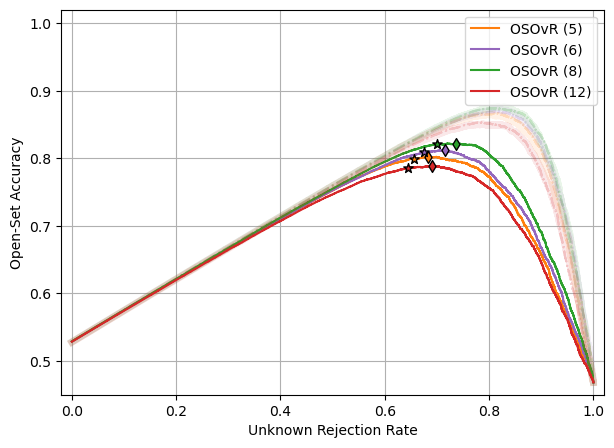

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9944	0.0232±0.0349	0.8497	0.8652	0.8662	0.8026	0.8648	0.7990
0.9938	0.0243±0.0367	0.8567	0.8727	0.8698	0.8119	0.8698	0.8086
0.9943	0.0241±0.0284	0.8701	0.8760	0.8745	0.8218	0.8743	0.8207
0.9935	0.0314±0.0368	0.8368	0.8506	0.8533	0.7888	0.8529	0.7859


In [21]:
evals.plot_OSAC(data_info, [CMAP_t10[1],CMAP_t10[4],CMAP_t10[2],CMAP_t10[3]], figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

#### Loss weighting parameter - neg 0
- Best C (OvR/OSOvR) : batch / global 
- Best F (OvR/OSOvR) : 0.2 / 3
- Best M (OvR/OSOvR) : 0.6 / 0.4

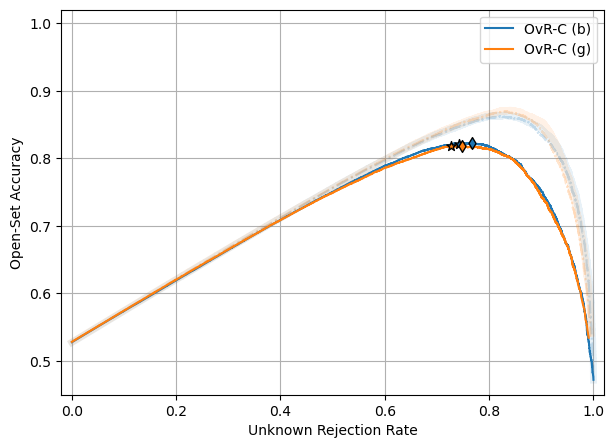

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9922	0.0367±0.0375	0.8845	0.8641	0.8624	0.8224	0.8615	0.8208
0.9932	0.0367±0.0361	0.8819	0.8711	0.8697	0.8187	0.8688	0.8179


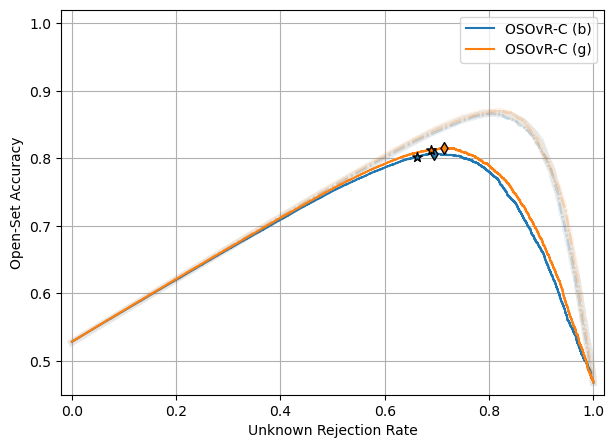

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9932	0.0371±0.0364	0.8519	0.8670	0.8664	0.8071	0.8652	0.8021
0.9938	0.0343±0.0400	0.8620	0.8690	0.8702	0.8152	0.8694	0.8126


In [23]:
# Class balancing - batch/global
data_info = ovr_data_info_2_T['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

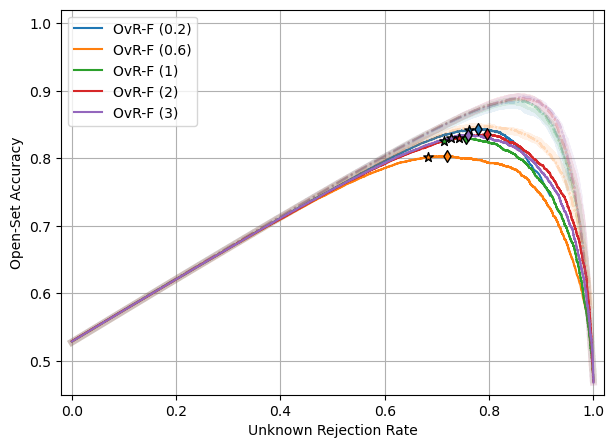

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9944	0.0273±0.0271	0.8934	0.8797	0.8843	0.8437	0.8829	0.8413
0.9936	0.0307±0.0325	0.8777	0.8470	0.8478	0.8036	0.8465	0.8013
0.9944	0.0303±0.0376	0.8949	0.8853	0.8877	0.8301	0.8873	0.8262
0.9948	0.0297±0.0365	0.9045	0.8909	0.8892	0.8357	0.8884	0.8306
0.9940	0.0282±0.0360	0.9013	0.8907	0.8914	0.8345	0.8894	0.8304


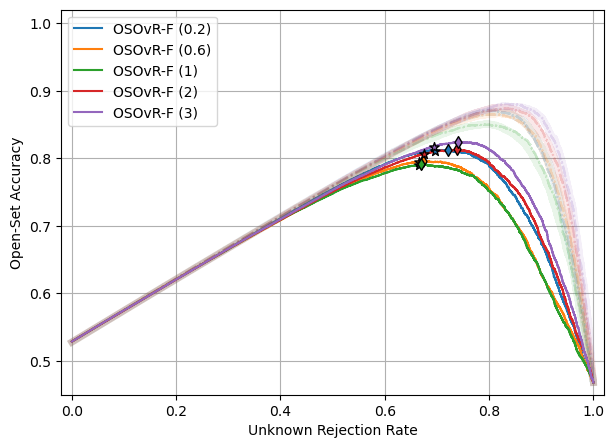

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9944	0.0259±0.0358	0.8593	0.8692	0.8709	0.8125	0.8690	0.8107
0.9943	0.0304±0.0456	0.8389	0.8671	0.8651	0.7955	0.8644	0.7952
0.9937	0.0323±0.0341	0.8352	0.8509	0.8499	0.7909	0.8494	0.7899
0.9938	0.0279±0.0336	0.8604	0.8756	0.8739	0.8131	0.8726	0.8062
0.9940	0.0268±0.0332	0.8719	0.8777	0.8809	0.8243	0.8795	0.8173


In [24]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_2_T['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

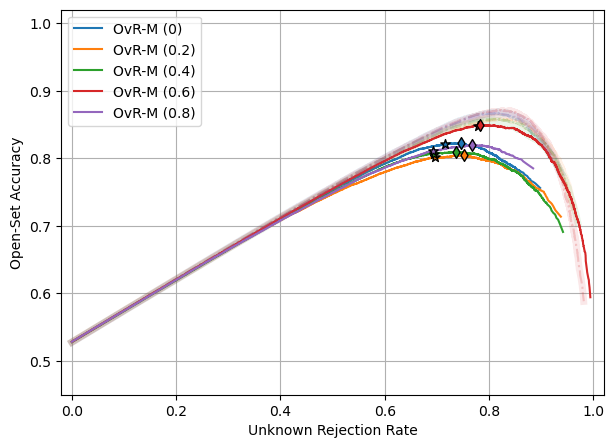

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9935	0.0268±0.0297	0.8773	0.8686	0.8663	0.8224	0.8659	0.8210
0.9936	0.0307±0.0357	0.8734	0.8608	0.8580	0.8046	0.8569	0.8014
0.9922	0.0340±0.0375	0.8754	0.8566	0.8590	0.8096	0.8579	0.8068
0.9930	0.0310±0.0289	0.9173	0.8704	0.8715	0.8492	0.8709	0.8484
0.9934	0.0328±0.0397	0.8749	0.8664	0.8669	0.8202	0.8668	0.8107


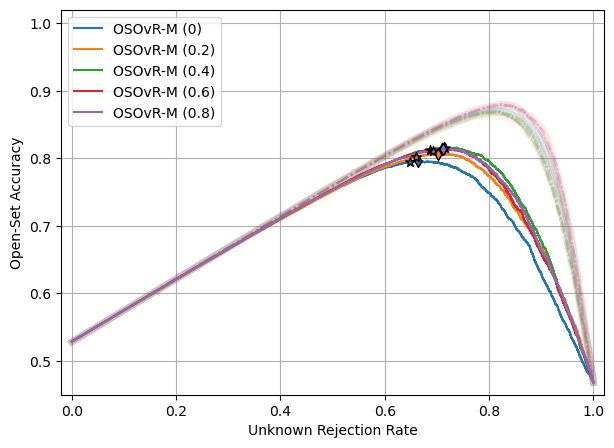

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9939	0.0284±0.0337	0.8377	0.8706	0.8702	0.7965	0.8696	0.7951
0.9933	0.0265±0.0327	0.8529	0.8652	0.8684	0.8065	0.8678	0.8022
0.9943	0.0274±0.0309	0.8620	0.8691	0.8691	0.8157	0.8673	0.8152
0.9941	0.0242±0.0318	0.8572	0.8801	0.8799	0.8141	0.8788	0.8118
0.9942	0.0245±0.0308	0.8586	0.8773	0.8786	0.8139	0.8777	0.8110


In [25]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_2_T['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

#### Loss weighting parameter - neg All
- Best C (OvR/OSOvR) : batch / batch 
- Best F (OvR/OSOvR) : 3 / 2
- Best M (OvR/OSOvR) : 0.2 / 0.4

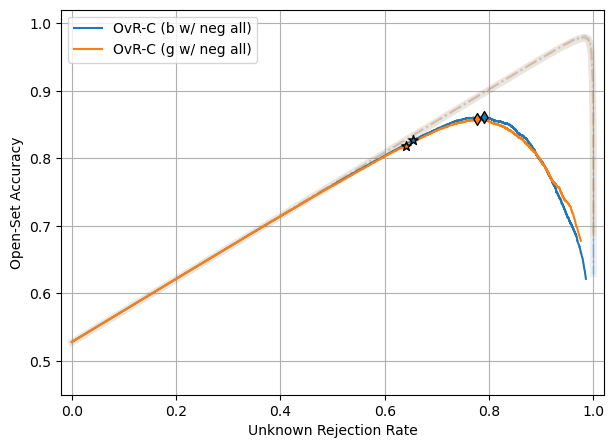

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9928	0.0162±0.0087	0.9176	0.9789	0.9801	0.8605	0.9799	0.8264
0.9929	0.0180±0.0108	0.9164	0.9786	0.9785	0.8576	0.9777	0.8188


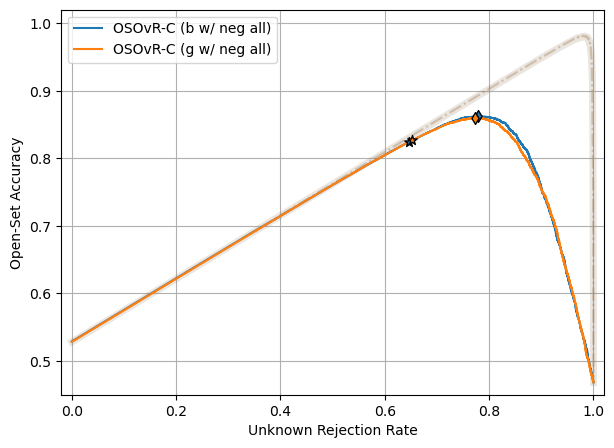

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9942	0.0138±0.0105	0.9027	0.9809	0.9817	0.8630	0.9811	0.8243
0.9931	0.0143±0.0088	0.9006	0.9801	0.9813	0.8598	0.9808	0.8265


In [26]:
# Class balancing - batch/global
data_info = ovr_data_info_3_T['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

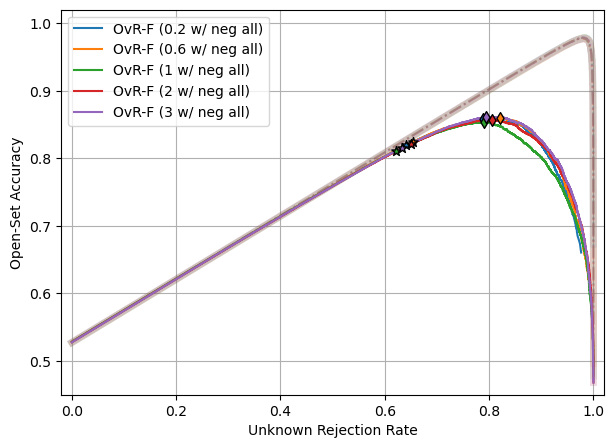

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9934	0.0157±0.0080	0.9205	0.9784	0.9791	0.8582	0.9790	0.8191
0.9936	0.0130±0.0050	0.9258	0.9783	0.9785	0.8597	0.9774	0.8242
0.9933	0.0220±0.0157	0.9188	0.9785	0.9786	0.8544	0.9780	0.8106
0.9920	0.0198±0.0135	0.9244	0.9772	0.9784	0.8568	0.9778	0.8212
0.9920	0.0177±0.0100	0.9268	0.9776	0.9789	0.8609	0.9783	0.8151


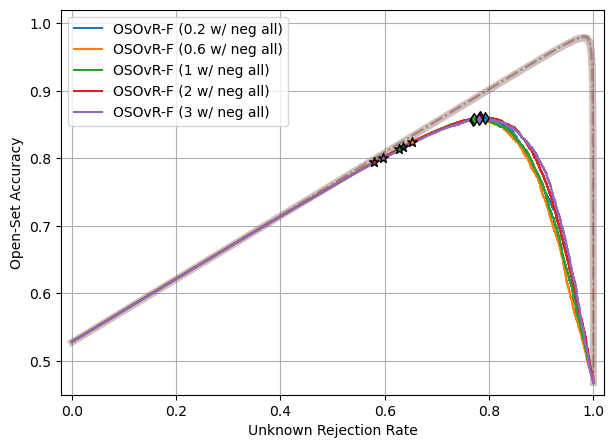

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9932	0.0173±0.0106	0.9028	0.9793	0.9815	0.8598	0.9808	0.8173
0.9937	0.0157±0.0126	0.8981	0.9788	0.9804	0.8571	0.9800	0.8243
0.9940	0.0174±0.0100	0.9007	0.9786	0.9801	0.8575	0.9798	0.8133
0.9926	0.0193±0.0088	0.9055	0.9780	0.9809	0.8605	0.9792	0.7941
0.9927	0.0169±0.0112	0.9065	0.9780	0.9788	0.8578	0.9787	0.8001


In [27]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_3_T['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

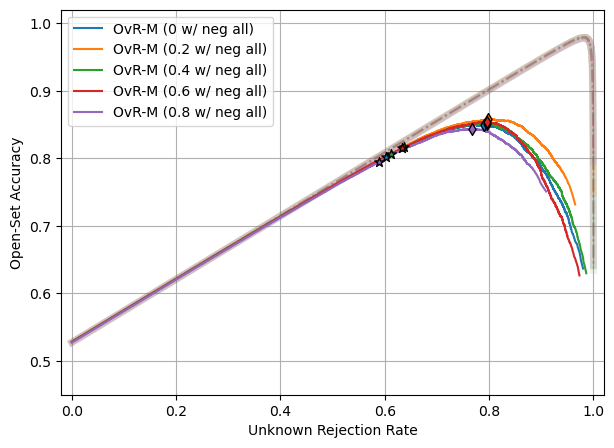

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9928	0.0185±0.0113	0.9104	0.9785	0.9798	0.8498	0.9797	0.8023
0.9922	0.0192±0.0100	0.9214	0.9790	0.9787	0.8579	0.9784	0.8172
0.9937	0.0168±0.0113	0.9151	0.9791	0.9798	0.8509	0.9797	0.8062
0.9927	0.0219±0.0109	0.9069	0.9788	0.9789	0.8536	0.9786	0.8148
0.9911	0.0209±0.0151	0.8916	0.9782	0.9785	0.8437	0.9782	0.7946


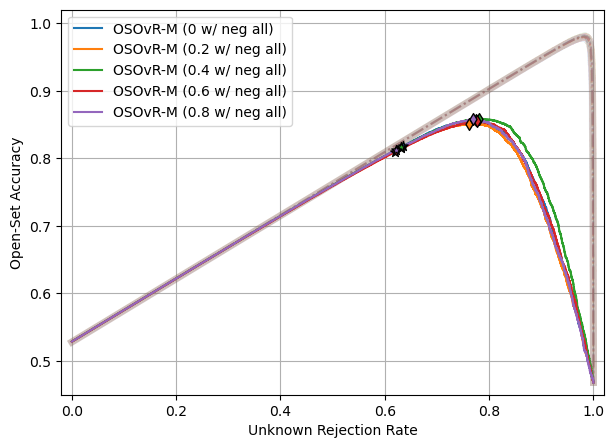

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9936	0.0171±0.0108	0.8968	0.9787	0.9800	0.8560	0.9797	0.8180
0.9935	0.0189±0.0126	0.8920	0.9797	0.9804	0.8509	0.9798	0.8148
0.9941	0.0200±0.0137	0.9046	0.9811	0.9811	0.8587	0.9807	0.8162
0.9937	0.0201±0.0117	0.8958	0.9795	0.9796	0.8548	0.9794	0.8091
0.9939	0.0194±0.0130	0.8952	0.9800	0.9819	0.8582	0.9813	0.8119


In [28]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_3_T['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)))
results = evals.print_metrics(data_info)

### Result 1. Multiclass classifier vs. a set of One-vs-Rest classifiers

RQ1. Can a set of one-vs-rest classifiers effectively replace a single multiclass classifier in neural networks for image classification tasks?

SM vs. OvR vs. OSOvR.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


In [29]:
data_info = sm_data_info_1 + ovr_data_info_1 + osovr_data_info_1

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']


In [30]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9931	0.0436±0.0376	0.8374	0.8497	0.8540	0.7954	0.8531	0.7940
0.9940	0.0322±0.0386	0.8795	0.8670	0.8700	0.8098	0.8691	0.8090
0.9943	0.0241±0.0284	0.8701	0.8760	0.8745	0.8218	0.8743	0.8207


<Figure size 500x500 with 0 Axes>

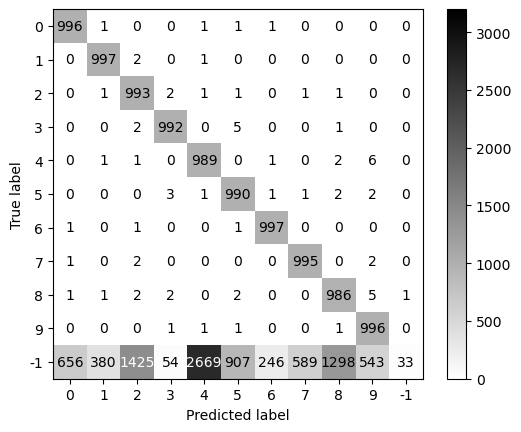

<Figure size 500x500 with 0 Axes>

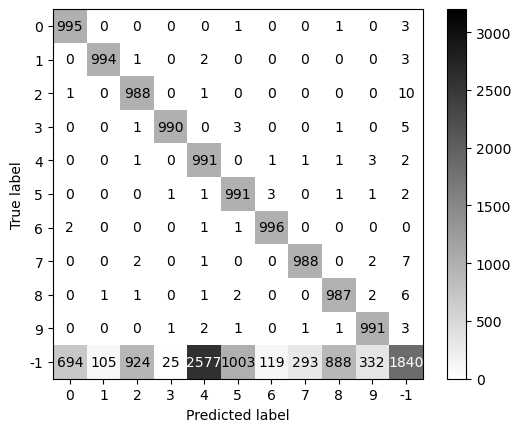

<Figure size 500x500 with 0 Axes>

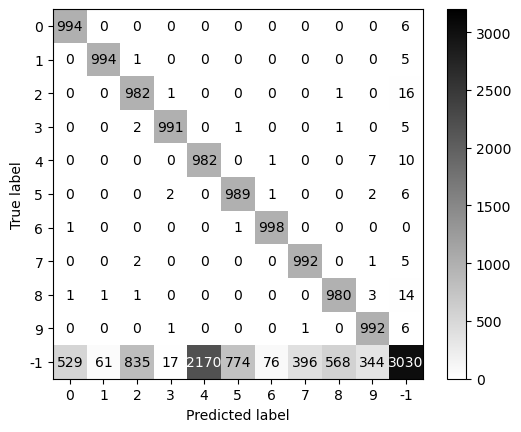

In [32]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,3200),
                         show_numbers=True, diag_sort=False)

[0.0056 0.0007 0.0003 0.0001] [9.916e-01 6.000e-04 4.000e-04 4.000e-04]
[0.0043 0.0005 0.0006 0.0002] [0.9789 0.003  0.0017 0.001 ]
[0.0042 0.001  0.0012 0.0007] [0.9815 0.0064 0.0021 0.0011]


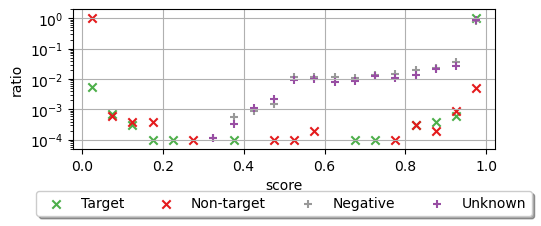

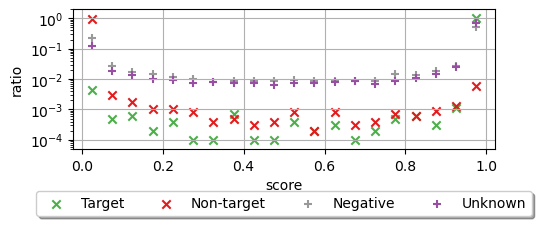

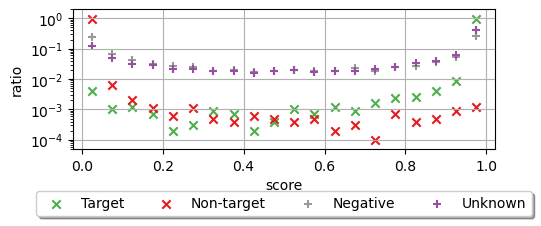

In [99]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(0.5e-4,2))

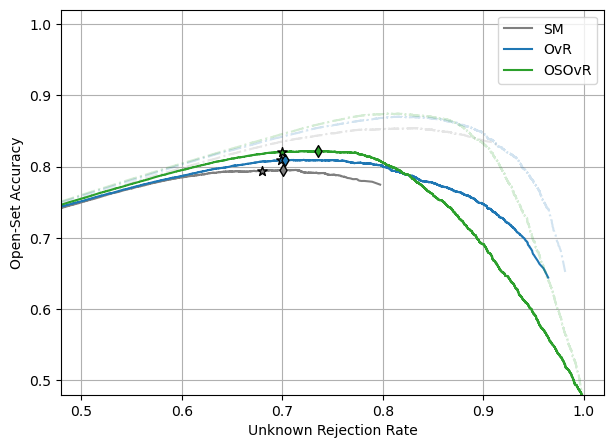

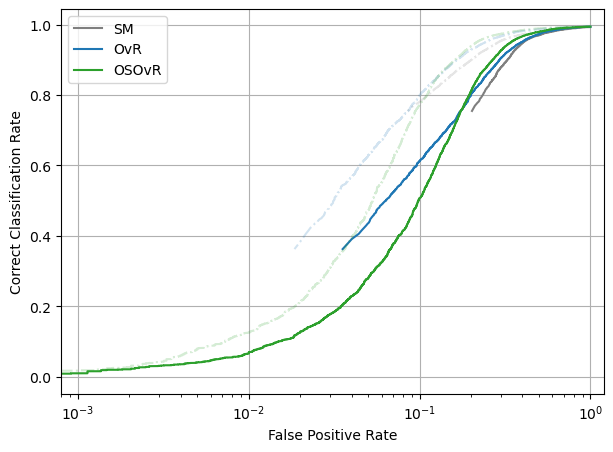

In [49]:
evals.plot_OSAC(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), show_val=False)

### Result 2. Loss weighting approaches for data imbalance issue
RQ2. Which loss weighting approach for a set of one-vs-rest classifiers reduces performance imbalance, and how does it impact overall classification performance?

OvR vs. -C vs. -F vs. -M

OSOvR vs. -C vs. -F vs. -M

- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve

#### OvR

In [24]:
data_info = ovr_data_info_2

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_b', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_02', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_06', 'OvR']


<Figure size 500x500 with 0 Axes>

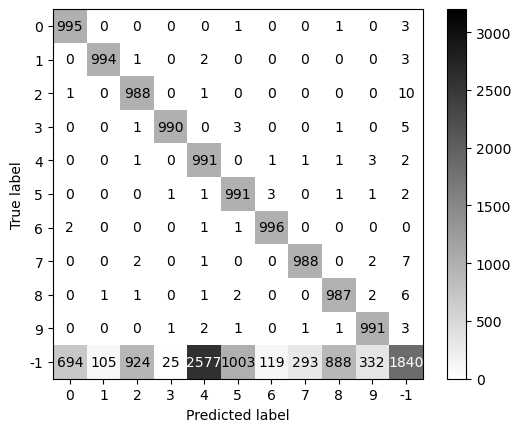

<Figure size 500x500 with 0 Axes>

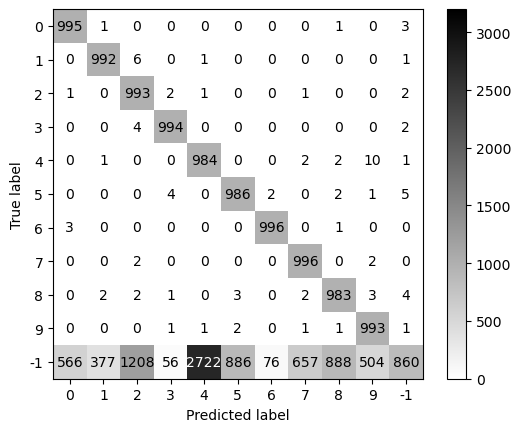

<Figure size 500x500 with 0 Axes>

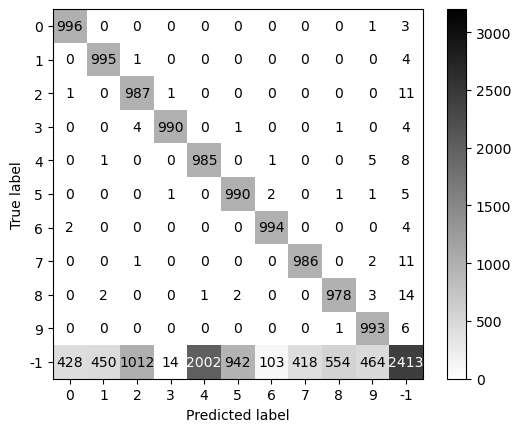

<Figure size 500x500 with 0 Axes>

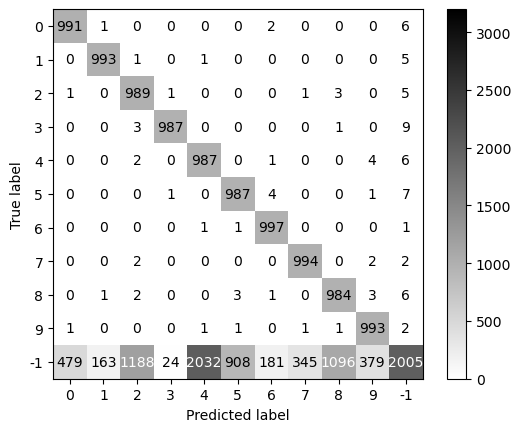

In [25]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,3200),
                         show_numbers=True, diag_sort=False)

[0.0043 0.0005 0.0006 0.0002] [0.9789 0.003  0.0017 0.001 ]
[0.0019 0.0008 0.0003 0.0002] [0.9232 0.013  0.0092 0.0061]
[0.007  0.0005 0.0006 0.0001] [9.844e-01 1.900e-03 8.000e-04 8.000e-04]
[0.0049 0.0005 0.0005 0.0004] [0.9759 0.0039 0.0014 0.001 ]


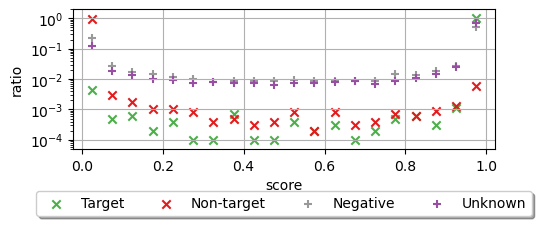

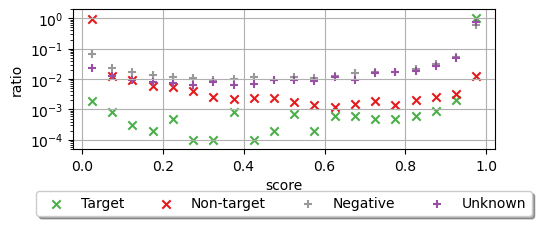

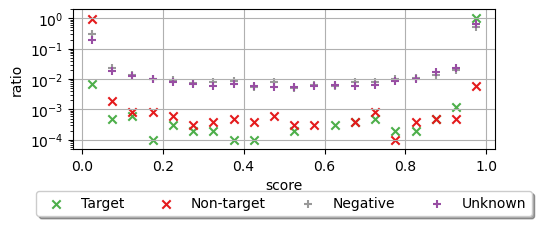

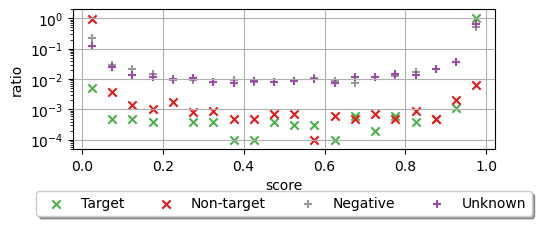

In [26]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(0.5e-4,2))

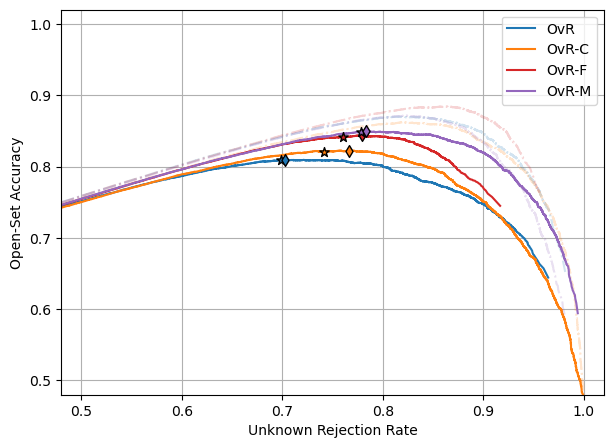

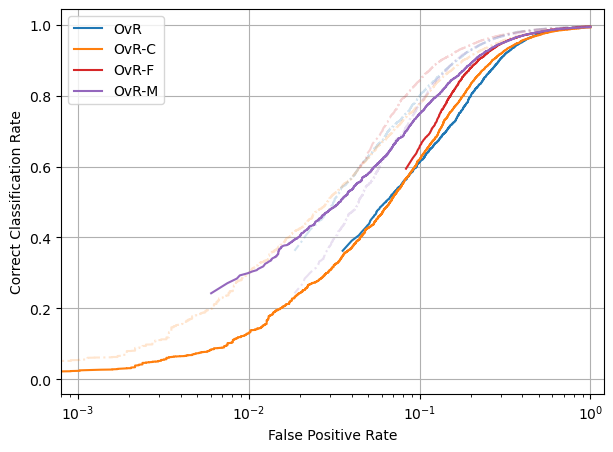

In [27]:
colors = [CMAP_t10[0],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

#### OSOvR

In [28]:
data_info = osovr_data_info_2

FPR_vals_all = np.linspace(1e-3,1,10**4)
FPR_vals = [1e-3,1e-2,1e-1,1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_3', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OpenSetOvR']


In [29]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9943	0.0262±0.0301	0.8701	0.8760	0.8745	0.8218	0.8743	0.8207
0.9938	0.0413±0.0434	0.8620	0.8690	0.8702	0.8152	0.8694	0.8126
0.9940	0.0296±0.0347	0.8719	0.8777	0.8809	0.8243	0.8795	0.8173
0.9943	0.0306±0.0322	0.8620	0.8691	0.8691	0.8157	0.8673	0.8152


<Figure size 500x500 with 0 Axes>

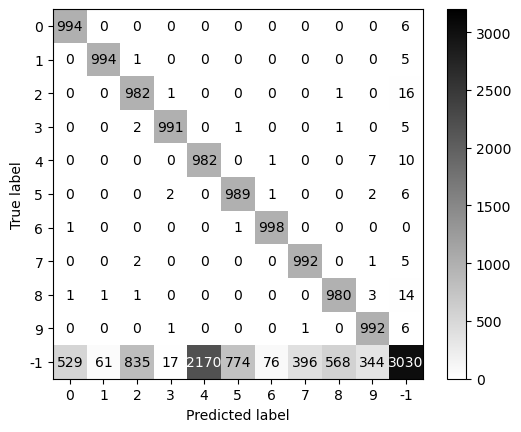

<Figure size 500x500 with 0 Axes>

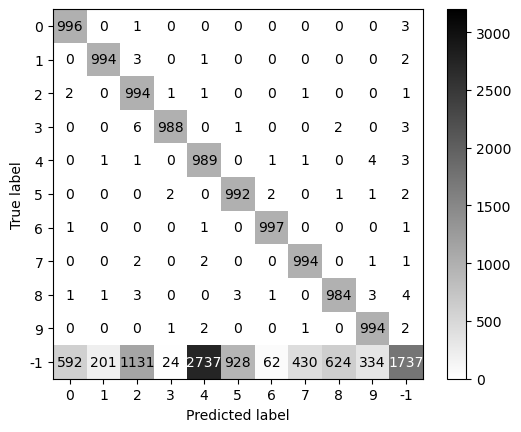

<Figure size 500x500 with 0 Axes>

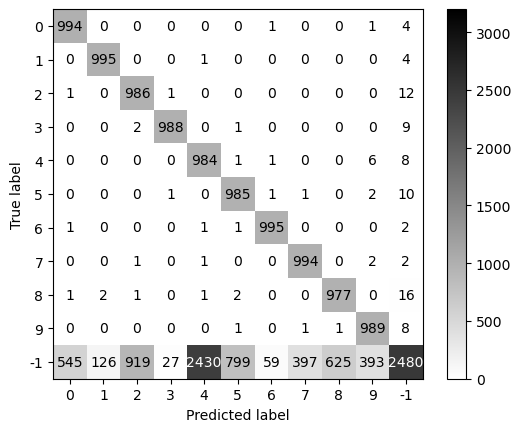

<Figure size 500x500 with 0 Axes>

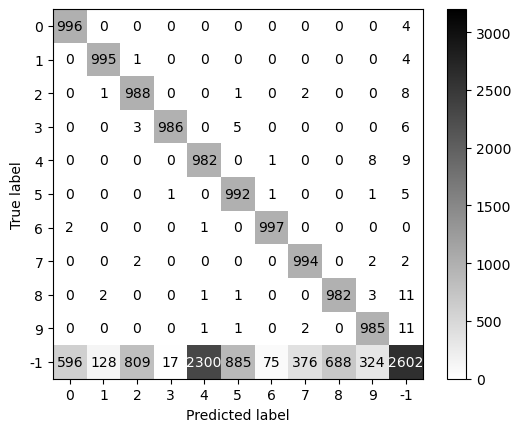

In [30]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,3200),
                         show_numbers=True, diag_sort=False)

[0.0042 0.001  0.0012 0.0007] [0.9815 0.0064 0.0021 0.0011]
[0.0015 0.0003 0.0002 0.0006] [0.9454 0.014  0.0072 0.0048]
[0.0018 0.0012 0.0002 0.0017] [0.9437 0.0235 0.0096 0.0047]
[0.0033 0.0011 0.0008 0.0008] [0.9708 0.0086 0.0032 0.0035]


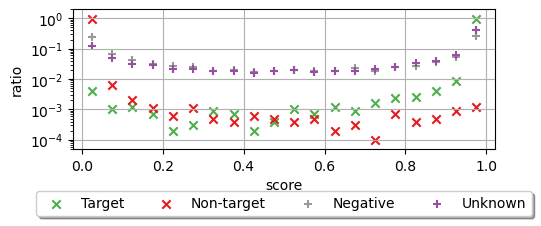

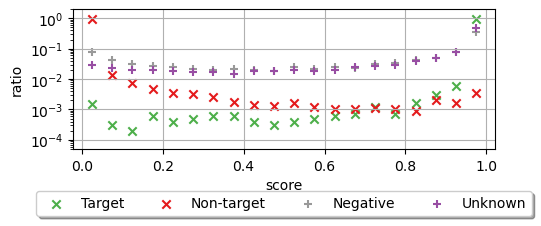

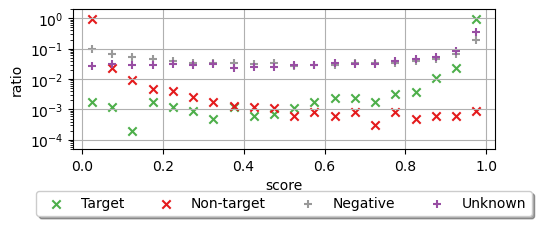

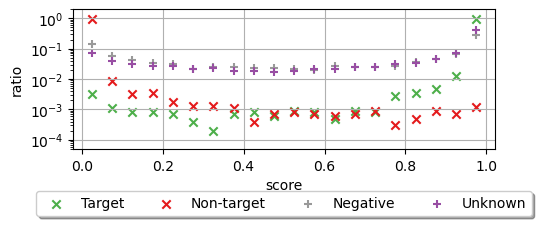

In [31]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(0.5e-4,2))

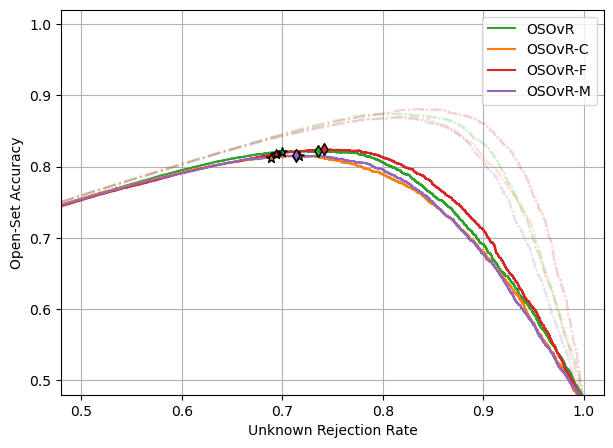

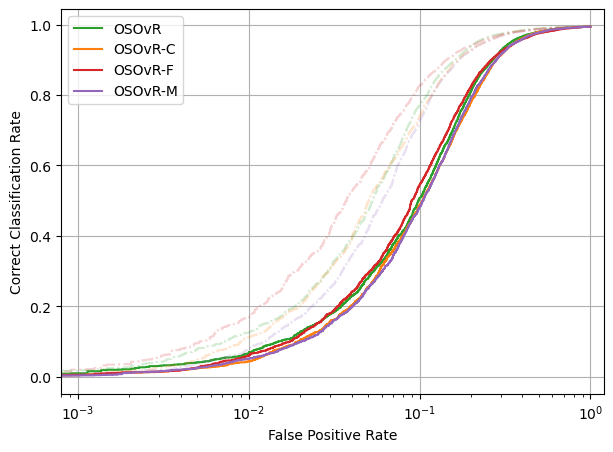

In [32]:
colors = [CMAP_t10[2],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

### Result 3.Including negatives in training 

RQ3. Does including negative samples in training improve open-set classification performance, and can loss weighting approaches mitigate the negative effects of increased dataset imbalance?

.
- OvR vs. OvR (- 10k) vs. OvR (- 20k) vs. OvR (- 30k) vs. OvR (- All) 
- OvR-C vs. OvR-C (- 10k) vs. OvR-C (- 20k) vs. OvR-C (- 30k) vs. OvR-C (- All) 
- OvR-F vs. OvR-F (- 10k) vs. OvR-F (- 20k) vs. OvR-F (- 30k) vs. OvR-F (- All) 
- OvR-M vs. OvR-M (- 10k) vs. OvR-M (- 20k) vs. OvR-M (- 30k) vs. OvR-M (- All) 

.
- OSOvR vs. OSOvR (- 10k) vs. OSOvR (- 20k) vs. OSOvR (- 30k) vs. OSOvR (- All) 
- OSOvR-C vs. OSOvR-C (- 10k) vs. OSOvR-C (- 20k) vs. OSOvR-C (- 30k) vs. OSOvR-C (- All) 
- OSOvR-F vs. OSOvR-F (- 10k) vs. OSOvR-F (- 20k) vs. OSOvR-F (- 30k) vs. OSOvR-F (- All) 
- OSOvR-M vs. OSOvR-M (- 10k) vs. OSOvR-M (- 20k) vs. OSOvR-M (- 30k) vs. OSOvR-M (- All) 

.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### OvR

##### X

In [45]:
data_info = ovr_data_info_2[:1]
data_info += ovr_data_info_3_10k[:1] + ovr_data_info_3_20k[:1] + ovr_data_info_3_30k[:1] + ovr_data_info_3[:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']


In [46]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9940	0.0322±0.0386	0.8795	0.8670	0.8700	0.8098	0.8691	0.8090
0.9939	0.0138±0.0101	0.9280	0.9729	0.9738	0.8671	0.9735	0.8260
0.9922	0.0212±0.0081	0.9032	0.9755	0.9747	0.8454	0.9742	0.8186
0.9936	0.0168±0.0129	0.9123	0.9766	0.9764	0.8534	0.9763	0.8101
0.9931	0.0189±0.0101	0.9121	0.9790	0.9780	0.8589	0.9778	0.8279


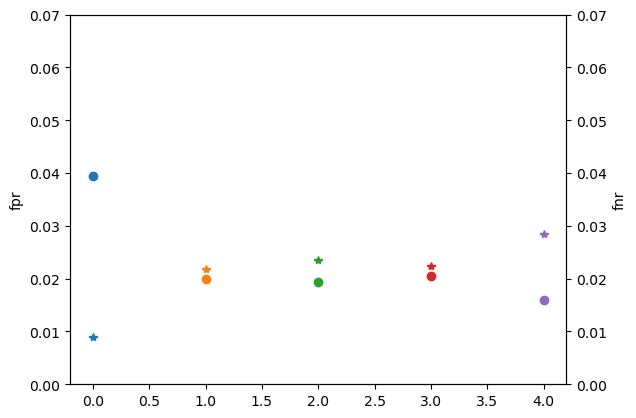

In [47]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

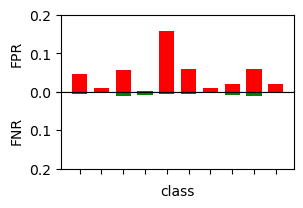

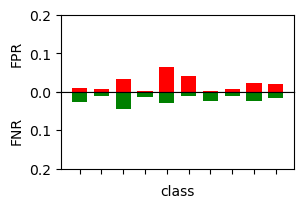

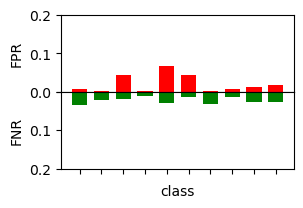

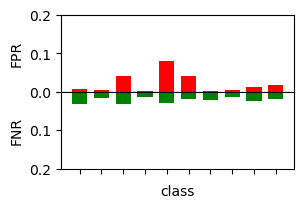

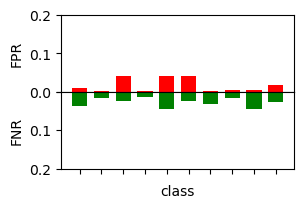

In [35]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### C

In [48]:
data_info = ovr_data_info_2[1:2]
data_info += ovr_data_info_3_10k[1:2] + ovr_data_info_3_20k[1:2] + ovr_data_info_3_30k[1:2] + ovr_data_info_3[1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_C_neg_0_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']


In [49]:
results_c = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9922	0.0367±0.0375	0.8845	0.8641	0.8624	0.8224	0.8615	0.8208
0.9925	0.0181±0.0162	0.9179	0.9722	0.9734	0.8529	0.9730	0.8182
0.9928	0.0167±0.0131	0.9159	0.9739	0.9744	0.8629	0.9736	0.8287
0.9932	0.0162±0.0077	0.9063	0.9760	0.9761	0.8522	0.9757	0.8205
0.9928	0.0162±0.0087	0.9176	0.9789	0.9801	0.8605	0.9799	0.8264


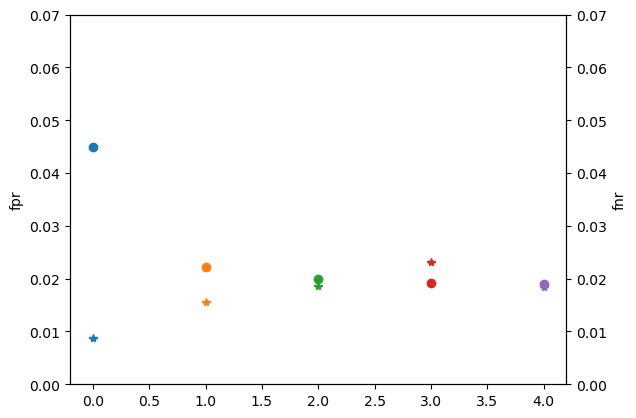

In [50]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

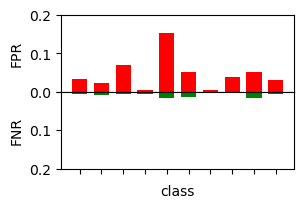

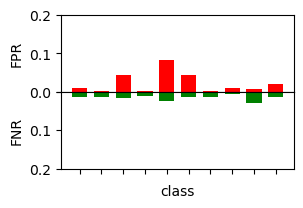

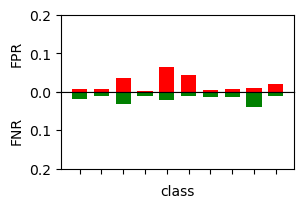

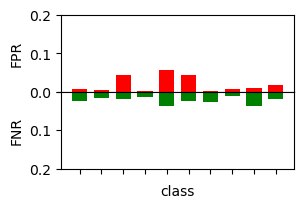

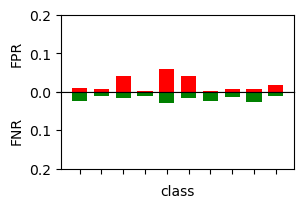

In [25]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### F

In [51]:
data_info = ovr_data_info_2[2:3]
data_info += ovr_data_info_3_10k[2:3] + ovr_data_info_3_20k[2:3] + ovr_data_info_3_30k[2:3] + ovr_data_info_3[2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_F_neg_0_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_3', 'OvR']


In [52]:
results_f = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9944	0.0273±0.0271	0.8934	0.8797	0.8843	0.8437	0.8829	0.8413
0.9936	0.0162±0.0152	0.9307	0.9743	0.9760	0.8684	0.9756	0.8284
0.9938	0.0165±0.0108	0.9279	0.9770	0.9763	0.8604	0.9751	0.8115
0.9930	0.0167±0.0093	0.9352	0.9787	0.9793	0.8677	0.9790	0.8231
0.9920	0.0177±0.0100	0.9268	0.9776	0.9789	0.8609	0.9783	0.8151


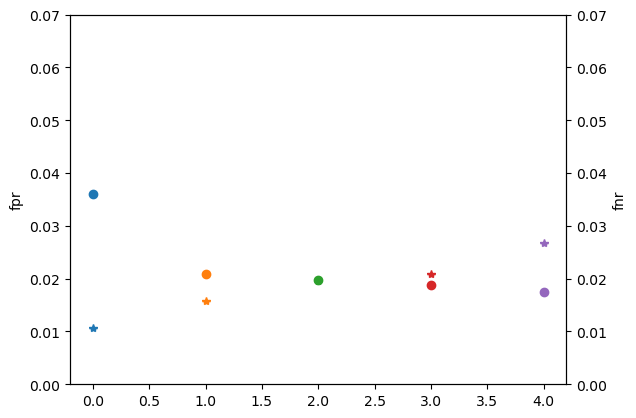

In [53]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

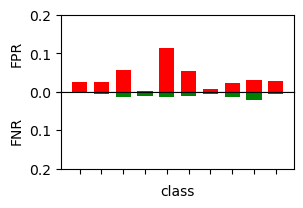

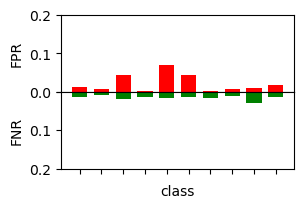

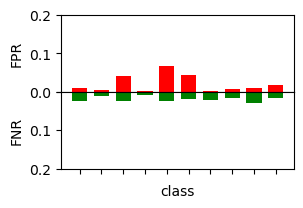

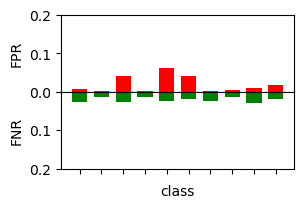

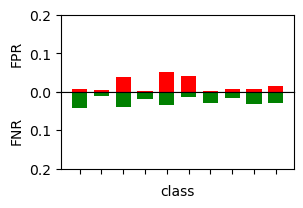

In [28]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### M

In [54]:
data_info = ovr_data_info_2[3:]
data_info += ovr_data_info_3_10k[3:] + ovr_data_info_3_20k[3:] + ovr_data_info_3_30k[3:] + ovr_data_info_3[3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_M_neg_0_06', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


In [55]:
results_m = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9930	0.0310±0.0289	0.9173	0.8704	0.8715	0.8492	0.8709	0.8484
0.9927	0.0251±0.0196	0.9005	0.9717	0.9733	0.8351	0.9728	0.7927
0.9932	0.0147±0.0102	0.9080	0.9752	0.9732	0.8543	0.9721	0.8094
0.9936	0.0202±0.0160	0.9117	0.9770	0.9780	0.8530	0.9774	0.7957
0.9922	0.0192±0.0100	0.9214	0.9790	0.9787	0.8579	0.9784	0.8172


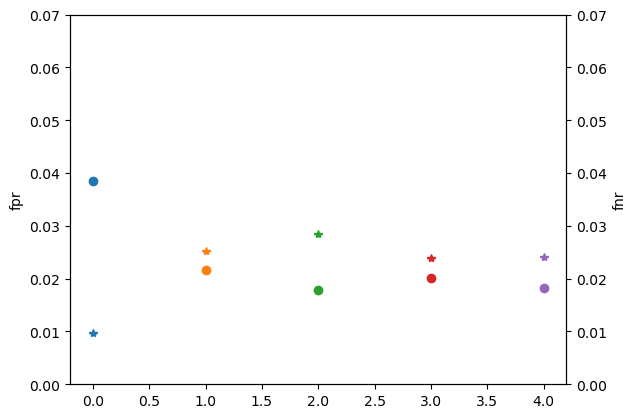

In [56]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

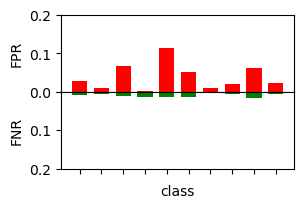

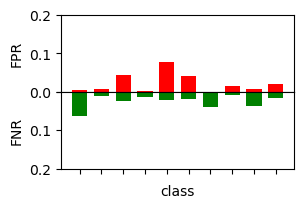

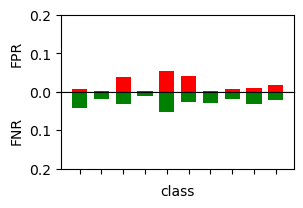

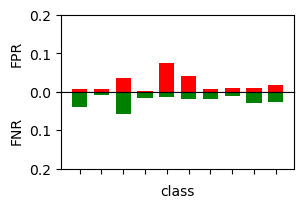

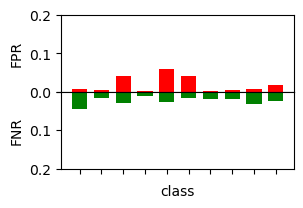

In [31]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### Plots

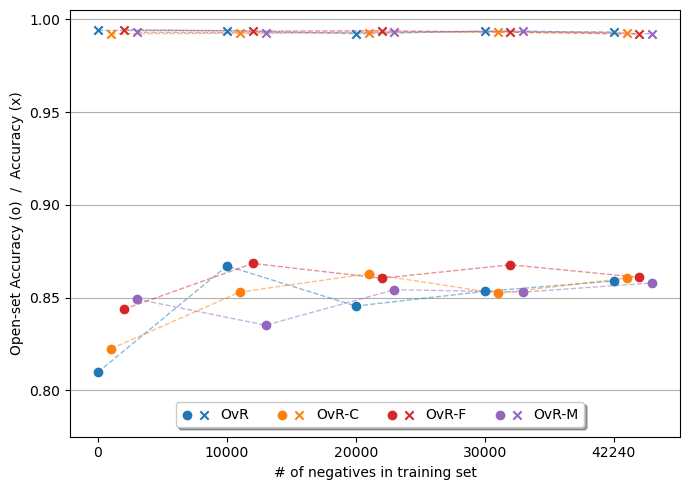

In [116]:
plot_results = [{'acc':results['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results['oosa']]}]
plot_results += [{'acc':results_c['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_c['oosa']]}]
plot_results += [{'acc':results_f['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_f['oosa']]}]
plot_results += [{'acc':results_m['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_m['oosa']]}]
plot_colors = [CMAP_t10[0], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OvR','OvR-C','OvR-F','OvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.775,1.005),(0.775,1.005)]
xticks = [0,10000,20000,30000,42240]

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

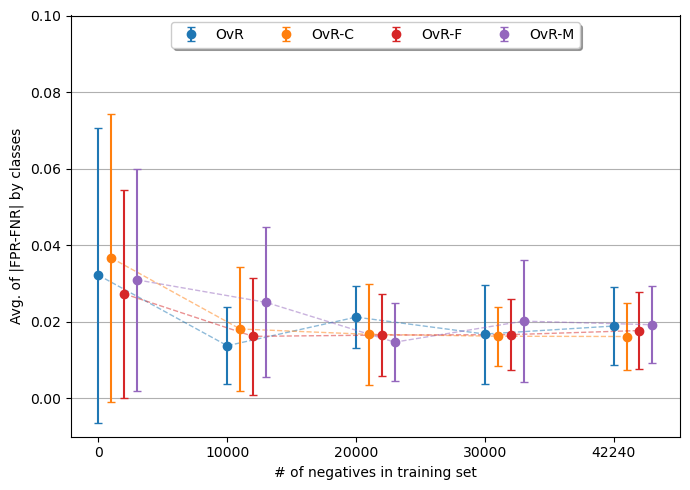

In [124]:
x = np.array([0,1,2,3,4])

plt.figure(figsize=(7,5))

avg = [res['avg'] for res in results['fpr_fnr']]
std = [res['std'] for res in results['fpr_fnr']]
min = [res['min'] for res in results['fpr_fnr']]
max = [res['max'] for res in results['fpr_fnr']]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[0], label='OvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[0], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_c['fpr_fnr']]
std = [res['std'] for res in results_c['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_f['fpr_fnr']]
std = [res['std'] for res in results_f['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_m['fpr_fnr']]
std = [res['std'] for res in results_m['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,10000,20000,30000,42240])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,0.1)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.tight_layout()

['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


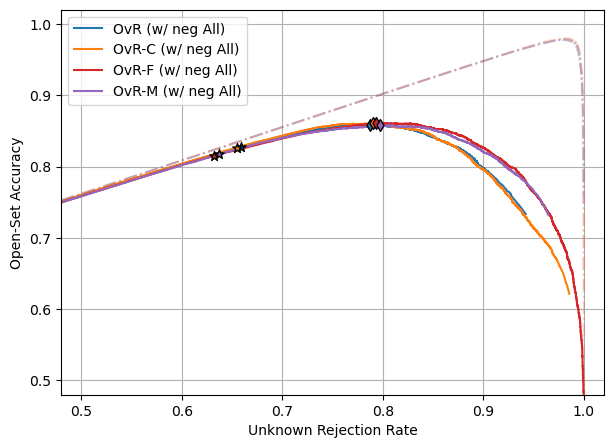

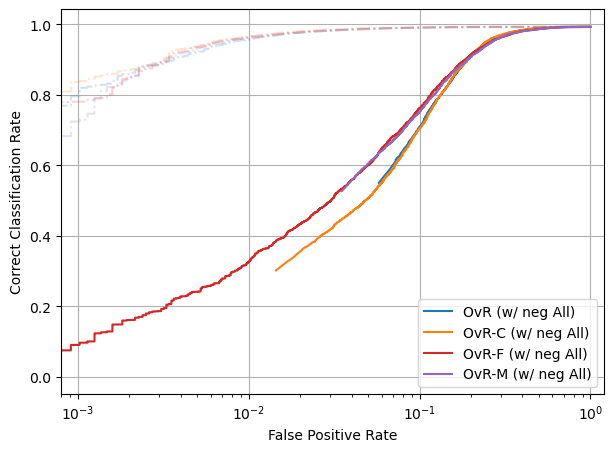

In [145]:
data_info = ovr_data_info_3

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

colors = [CMAP_t10[0],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

#### OSOvR

##### X

In [69]:
data_info = osovr_data_info_2[:1]
data_info += osovr_data_info_3_10k[:1] + osovr_data_info_3_20k[:1] + osovr_data_info_3_30k[:1] + osovr_data_info_3[:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OpenSetOvR']


In [70]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9943	0.0262±0.0301	0.8701	0.8760	0.8745	0.8218	0.8743	0.8207
0.9940	0.0147±0.0102	0.8939	0.9745	0.9760	0.8553	0.9757	0.8250
0.9938	0.0168±0.0092	0.8960	0.9769	0.9782	0.8546	0.9779	0.8221
0.9935	0.0148±0.0092	0.8967	0.9786	0.9776	0.8573	0.9771	0.8252
0.9939	0.0174±0.0123	0.8921	0.9800	0.9805	0.8526	0.9804	0.8172


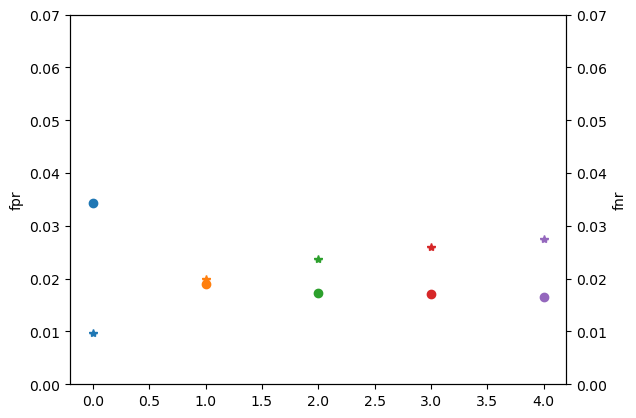

In [71]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

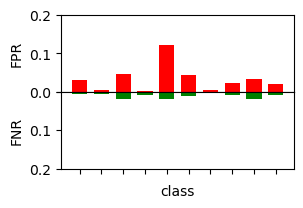

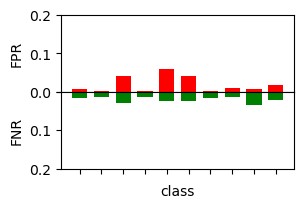

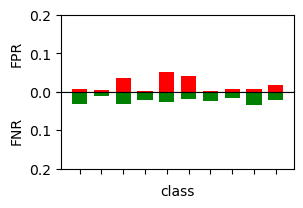

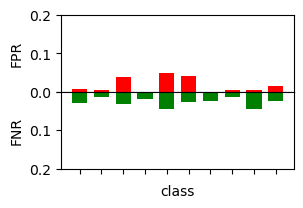

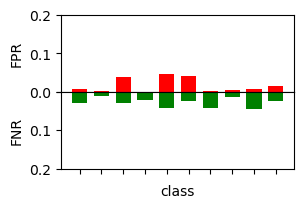

In [148]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### C

In [72]:
data_info = osovr_data_info_2[1:2]
data_info += osovr_data_info_3_10k[1:2] + osovr_data_info_3_20k[1:2] + osovr_data_info_3_30k[1:2] + osovr_data_info_3[1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OpenSetOvR']


In [73]:
results_c = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9938	0.0413±0.0434	0.8620	0.8690	0.8702	0.8152	0.8694	0.8126
0.9942	0.0180±0.0190	0.8946	0.9744	0.9738	0.8536	0.9736	0.8177
0.9940	0.0158±0.0117	0.8961	0.9778	0.9789	0.8579	0.9787	0.8238
0.9930	0.0154±0.0127	0.9043	0.9778	0.9791	0.8632	0.9790	0.8193
0.9942	0.0133±0.0117	0.9027	0.9809	0.9817	0.8630	0.9811	0.8243


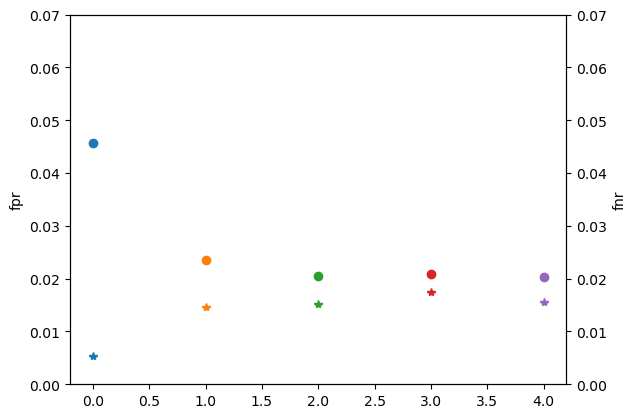

In [74]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

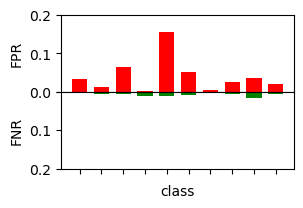

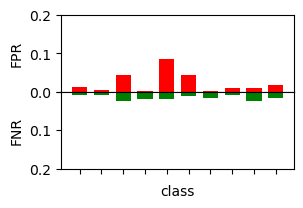

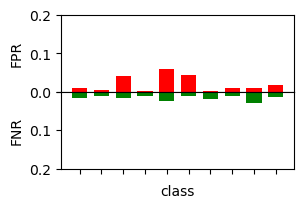

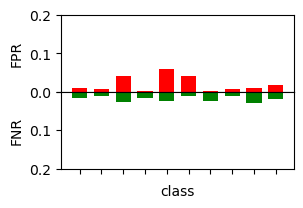

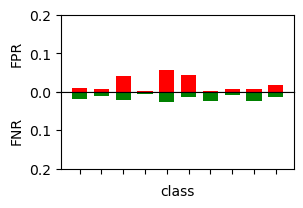

In [151]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### F

In [75]:
data_info = osovr_data_info_2[2:3]
data_info += osovr_data_info_3_10k[2:3] + osovr_data_info_3_20k[2:3] + osovr_data_info_3_30k[2:3] + osovr_data_info_3[2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_F_neg_0_3', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_2', 'OpenSetOvR']


In [76]:
results_f = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9940	0.0296±0.0347	0.8719	0.8777	0.8809	0.8243	0.8795	0.8173
0.9944	0.0143±0.0099	0.9082	0.9719	0.9733	0.8611	0.9729	0.8249
0.9933	0.0155±0.0092	0.9042	0.9755	0.9754	0.8599	0.9754	0.8127
0.9936	0.0165±0.0102	0.8971	0.9768	0.9790	0.8533	0.9781	0.8143
0.9926	0.0192±0.0093	0.9055	0.9780	0.9809	0.8605	0.9792	0.7941


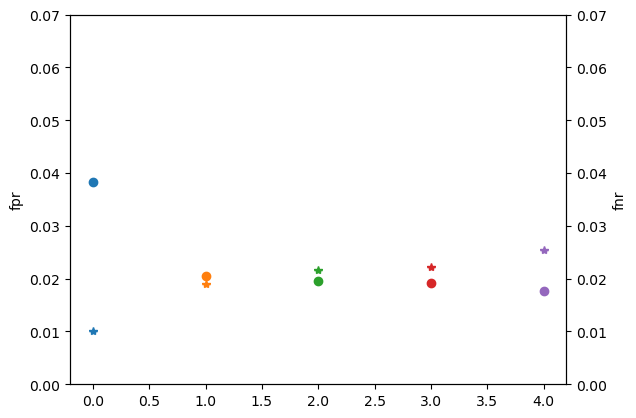

In [77]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

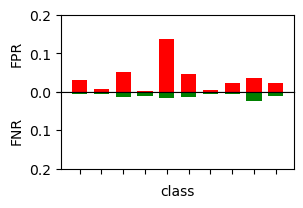

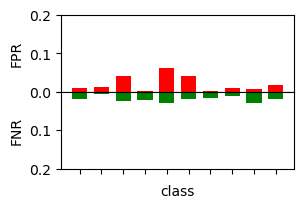

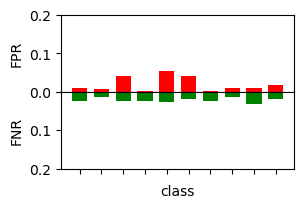

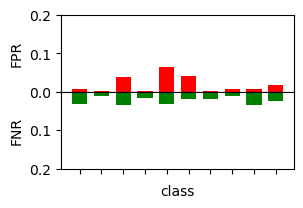

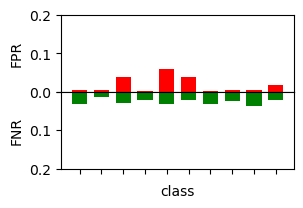

In [154]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### M

In [78]:
data_info = osovr_data_info_2[3:]
data_info += osovr_data_info_3_10k[3:] + osovr_data_info_3_20k[3:] + osovr_data_info_3_30k[3:] + osovr_data_info_3[3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_04', 'OpenSetOvR']


In [79]:
results_m = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9943	0.0306±0.0322	0.8620	0.8691	0.8691	0.8157	0.8673	0.8152
0.9935	0.0170±0.0104	0.8931	0.9734	0.9755	0.8537	0.9746	0.8264
0.9944	0.0148±0.0109	0.8980	0.9775	0.9777	0.8561	0.9772	0.8186
0.9939	0.0168±0.0089	0.8958	0.9781	0.9785	0.8554	0.9776	0.8248
0.9941	0.0193±0.0137	0.9046	0.9811	0.9811	0.8587	0.9807	0.8162


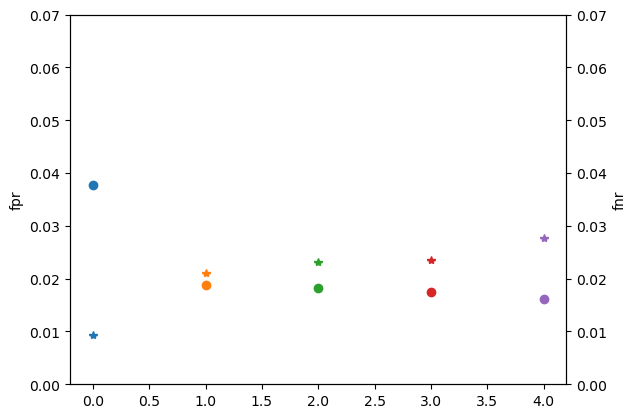

In [80]:
evals.plot_fpr_fnr_v2(data_info, CMAP_t10, ylim=(0, 0.07))

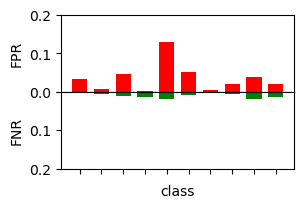

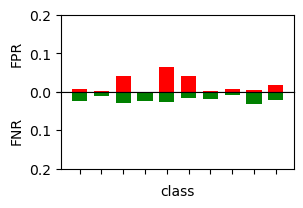

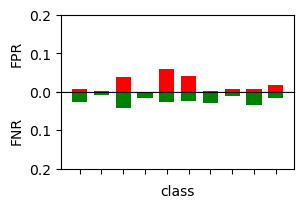

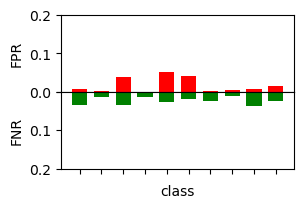

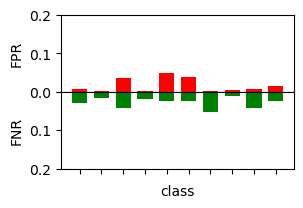

In [157]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

##### Plots

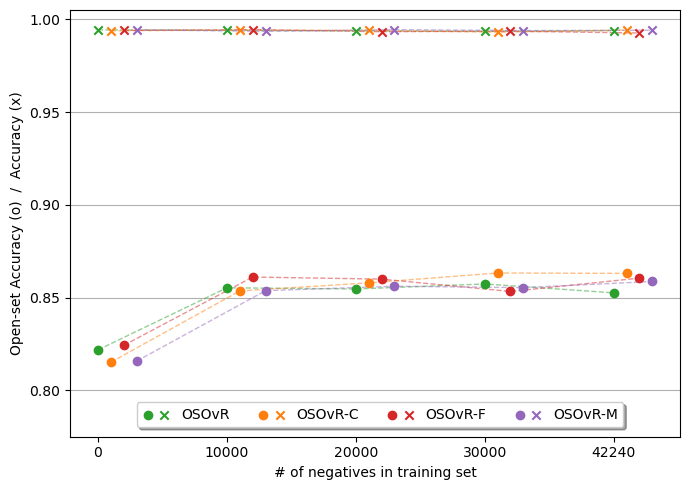

In [160]:
plot_results = [{'acc':results['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results['oosa']]}]
plot_results += [{'acc':results_c['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_c['oosa']]}]
plot_results += [{'acc':results_f['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_f['oosa']]}]
plot_results += [{'acc':results_m['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_m['oosa']]}]
plot_colors = [CMAP_t10[2], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OSOvR','OSOvR-C','OSOvR-F','OSOvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.775,1.005),(0.775,1.005)]
xticks = [0,10000,20000,30000,42240]

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

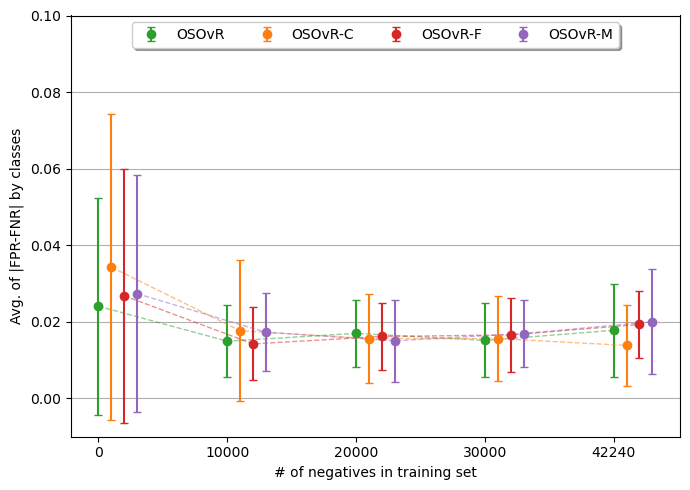

In [159]:
x = np.array([0,1,2,3,4])

plt.figure(figsize=(7,5))

avg = [res['avg'] for res in results['fpr_fnr']]
std = [res['std'] for res in results['fpr_fnr']]
min = [res['min'] for res in results['fpr_fnr']]
max = [res['max'] for res in results['fpr_fnr']]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[2], label='OSOvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[2], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_c['fpr_fnr']]
std = [res['std'] for res in results_c['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OSOvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_f['fpr_fnr']]
std = [res['std'] for res in results_f['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OSOvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_m['fpr_fnr']]
std = [res['std'] for res in results_m['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OSOvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,10000,20000,30000,42240])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,0.1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.grid(axis='y')
plt.tight_layout()

['SmallScale', '_RQ3', 'LeNet_neg_All', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_04', 'OpenSetOvR']


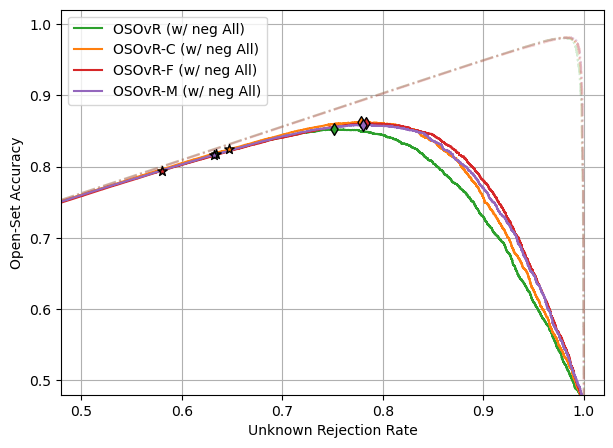

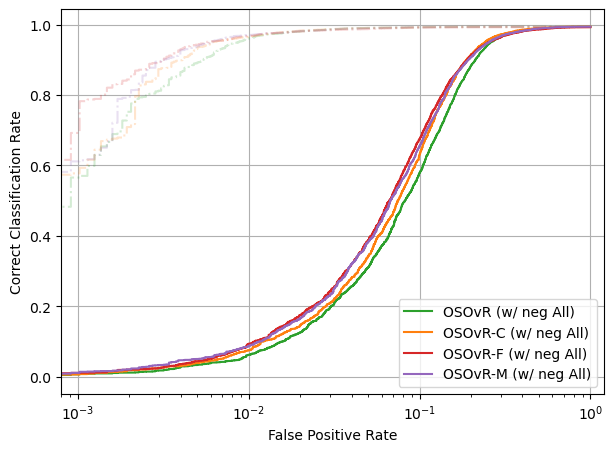

In [143]:
data_info = osovr_data_info_3

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

colors = [CMAP_t10[2],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

#### Overall

##### OvR

In [173]:
data_info = eos_data_info_3[-1:] + ovr_data_info_3

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


<Figure size 500x500 with 0 Axes>

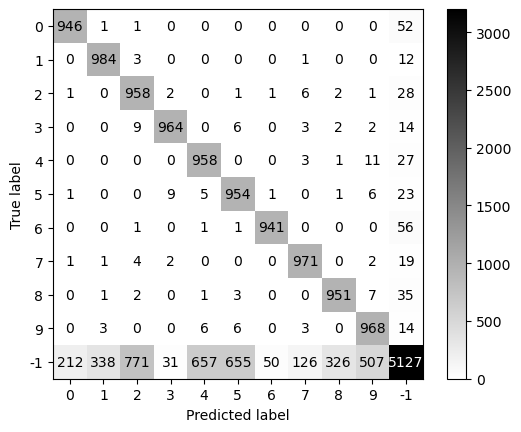

<Figure size 500x500 with 0 Axes>

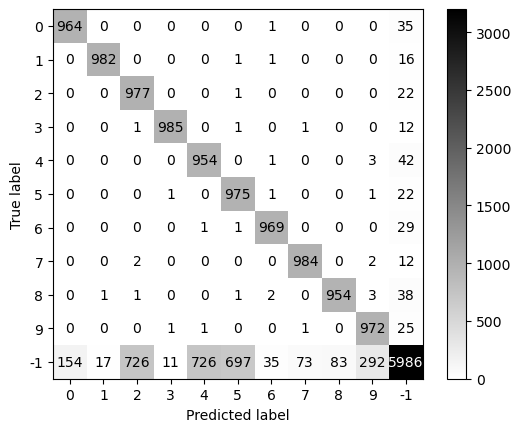

<Figure size 500x500 with 0 Axes>

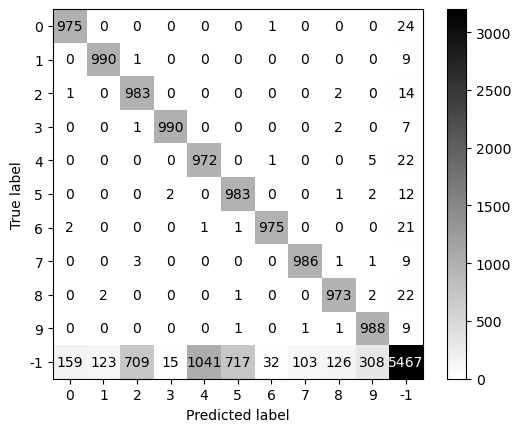

<Figure size 500x500 with 0 Axes>

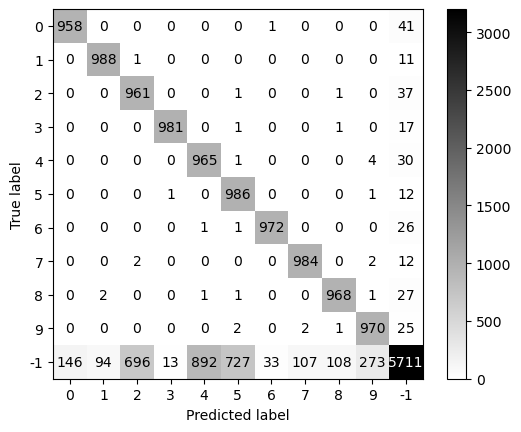

<Figure size 500x500 with 0 Axes>

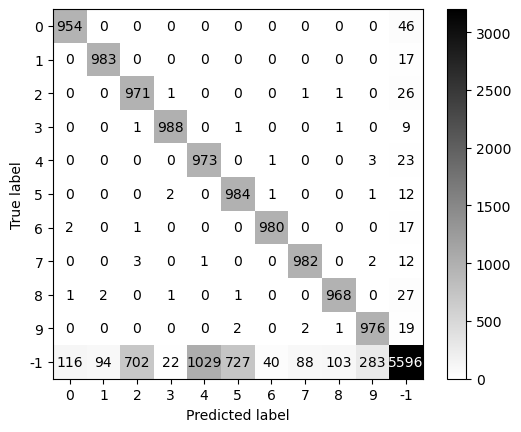

In [174]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,3200),
                         show_numbers=True, diag_sort=False)

[0.0062 0.004  0.0066 0.004 ] [0.9275 0.0234 0.016  0.0065]
[0.0212 0.0011 0.0013 0.0005] [9.896e-01 1.700e-03 3.000e-04 5.000e-04]
[0.012  0.0014 0.0015 0.0003] [9.816e-01 2.700e-03 1.400e-03 9.000e-04]
[0.0067 0.0031 0.0021 0.0023] [0.9425 0.0249 0.01   0.0065]
[0.0186 0.0012 0.0011 0.0003] [9.843e-01 1.800e-03 1.100e-03 4.000e-04]


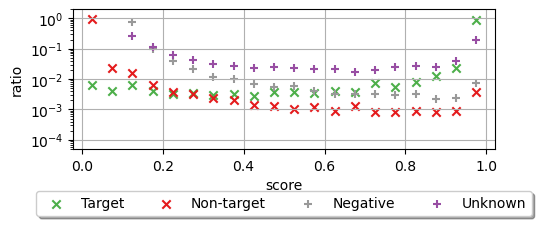

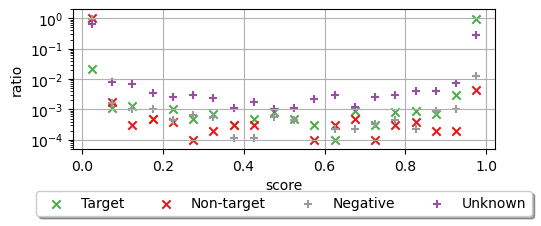

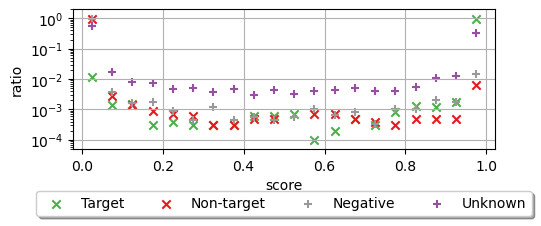

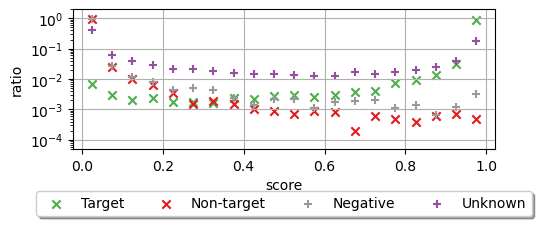

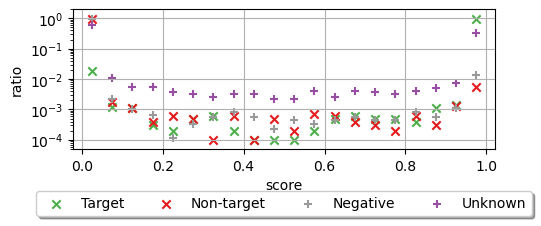

In [175]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(0.5e-4,2))

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9774	0.0203±0.0184	0.9059	0.9609	0.9619	0.8483	0.9613	0.8018
0.9931	0.0189±0.0101	0.9121	0.9790	0.9780	0.8589	0.9778	0.8279
0.9928	0.0162±0.0087	0.9176	0.9789	0.9801	0.8605	0.9799	0.8264
0.9920	0.0177±0.0100	0.9268	0.9776	0.9789	0.8609	0.9783	0.8151
0.9922	0.0192±0.0100	0.9214	0.9790	0.9787	0.8579	0.9784	0.8172


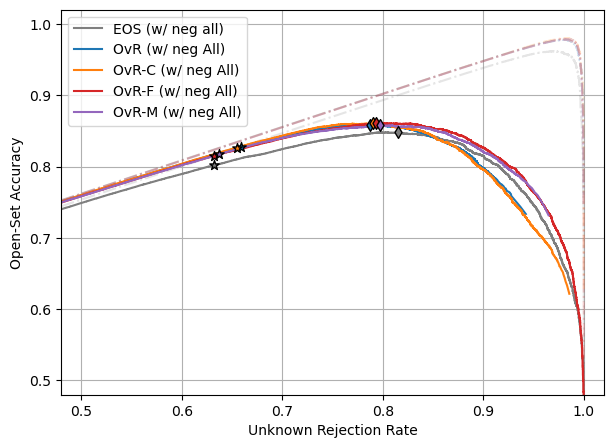

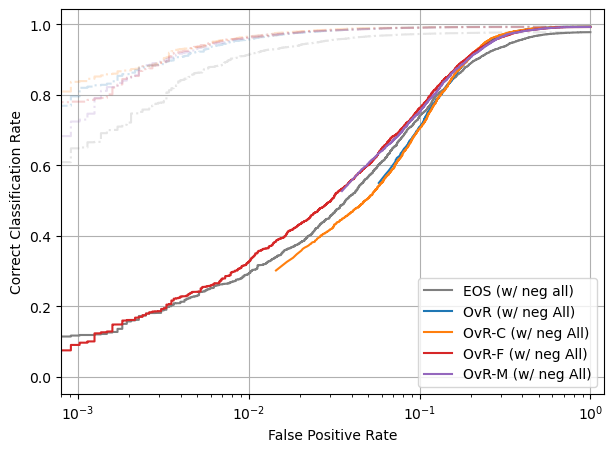

In [176]:
results = evals.print_metrics(data_info)

colors = [CMAP_t10[7], CMAP_t10[0],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

##### OSOvR

In [177]:
data_info = eos_data_info_3[-1:] + osovr_data_info_3

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_04', 'OpenSetOvR']


<Figure size 500x500 with 0 Axes>

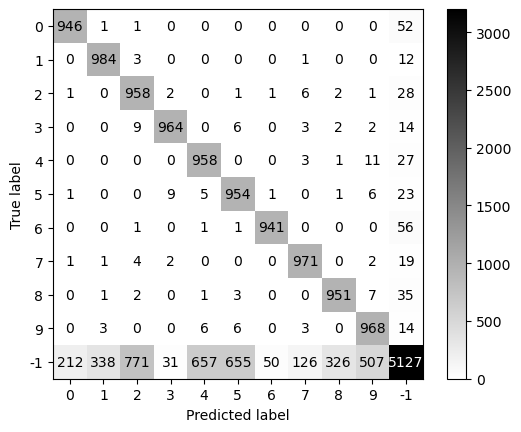

<Figure size 500x500 with 0 Axes>

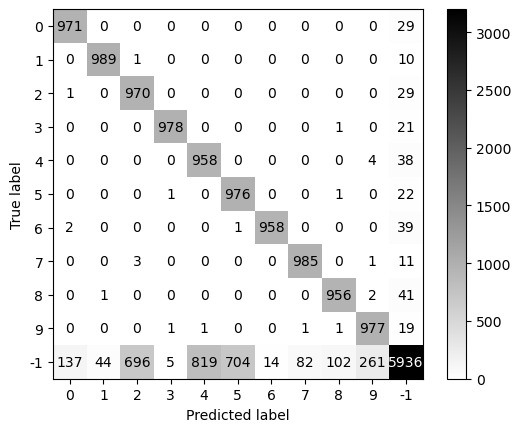

<Figure size 500x500 with 0 Axes>

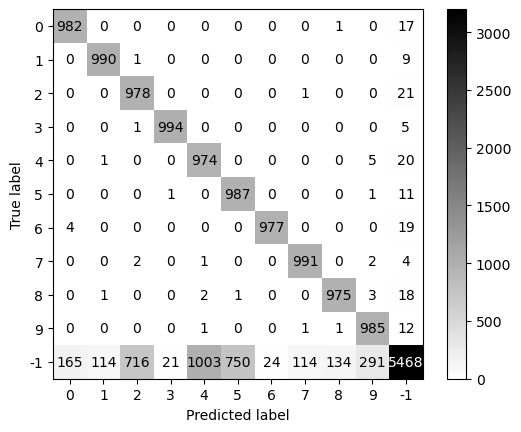

<Figure size 500x500 with 0 Axes>

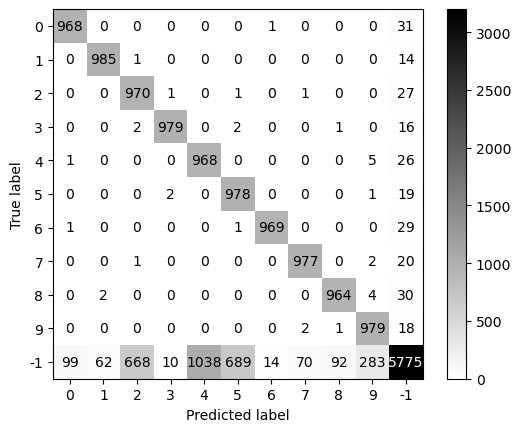

<Figure size 500x500 with 0 Axes>

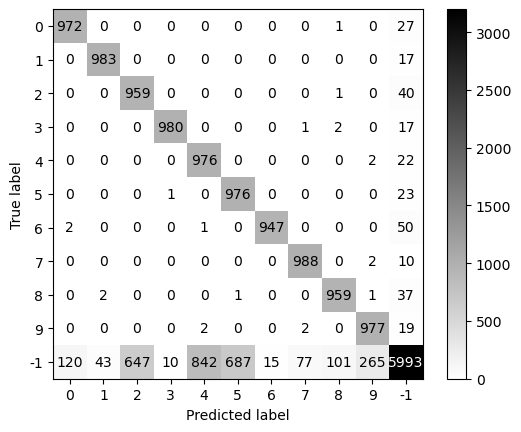

In [178]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,3200),
                         show_numbers=True, diag_sort=False)

[0.0062 0.004  0.0066 0.004 ] [0.9275 0.0234 0.016  0.0065]
[0.0114 0.0033 0.0024 0.0022] [0.9851 0.0039 0.0019 0.0016]
[0.0057 0.0016 0.0014 0.0011] [0.9678 0.0101 0.0051 0.0035]
[0.0088 0.0029 0.0014 0.0018] [0.9699 0.012  0.005  0.0022]
[0.0127 0.0031 0.0019 0.0014] [9.872e-01 2.700e-03 2.100e-03 8.000e-04]


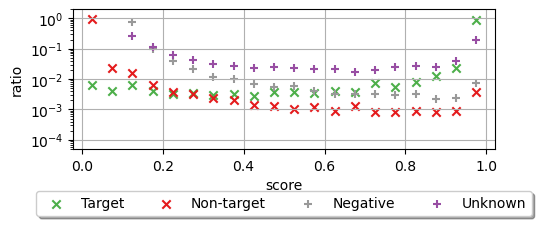

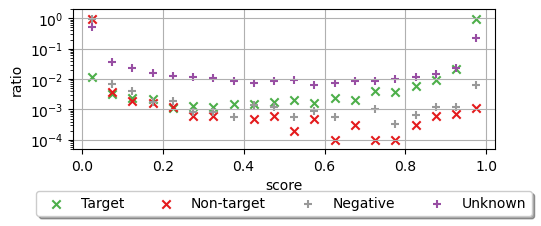

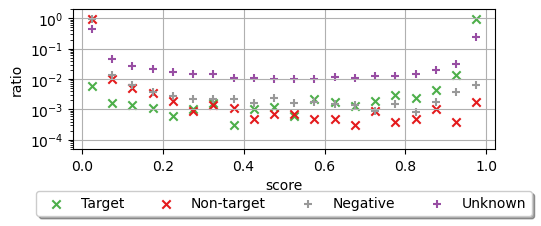

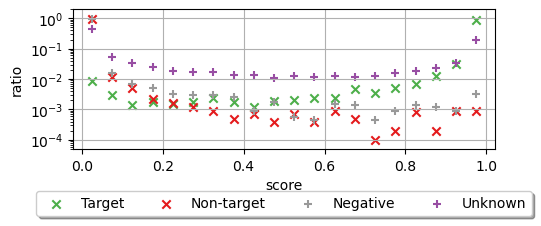

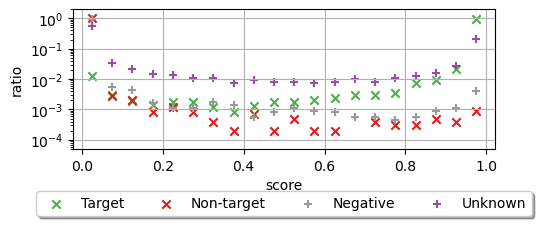

In [179]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(0.5e-4,2))

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.9774	0.0203±0.0184	0.9059	0.9609	0.9619	0.8483	0.9613	0.8018
0.9939	0.0178±0.0122	0.8921	0.9800	0.9805	0.8526	0.9804	0.8172
0.9942	0.0138±0.0105	0.9027	0.9809	0.9817	0.8630	0.9811	0.8243
0.9926	0.0193±0.0088	0.9055	0.9780	0.9809	0.8605	0.9792	0.7941
0.9941	0.0200±0.0137	0.9046	0.9811	0.9811	0.8587	0.9807	0.8162


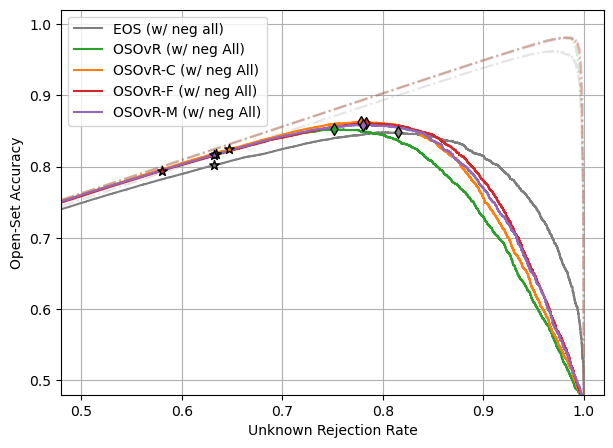

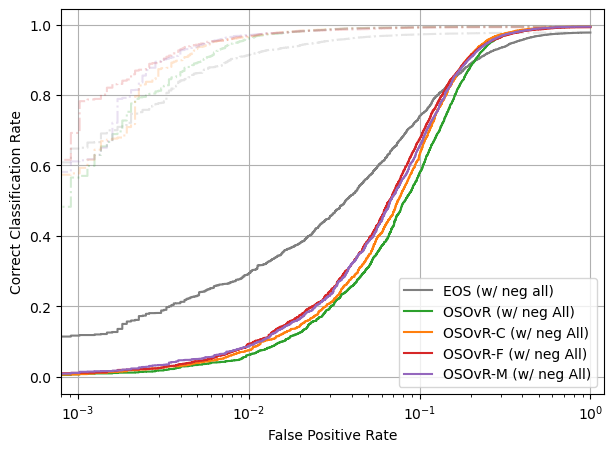

In [180]:
results = evals.print_metrics(data_info)

colors = [CMAP_t10[7], CMAP_t10[2],CMAP_t10[1],CMAP_t10[3],CMAP_t10[4]]
evals.plot_OSAC(data_info, colors=colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors=colors, figsize=(7,5), show_val=False)

### __ Feature space dimensionality

In [52]:
data_info = ovr_data_info_D + osovr_data_info_D
for idx in range(len(data_info)):
    print(idx, data_info[idx]['info'])

0 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OvR']
1 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OvR']
2 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OvR']
3 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3', 'OvR']
4 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4', 'OvR']
5 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2_neg_All', 'OvR']
6 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5_neg_All', 'OvR']
7 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10_neg_All', 'OvR']
8 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3_neg_All', 'OvR']
9 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4_neg_All', 'OvR']
10 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OpenSetOvR']
11 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OpenSetOvR']
12 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OpenSetOvR']
13 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3', 'OpenSetOvR']
14 ['SmallScale', '_Discussion', 'LeNet_plu

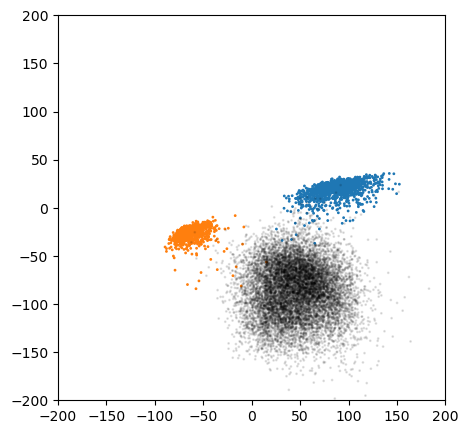

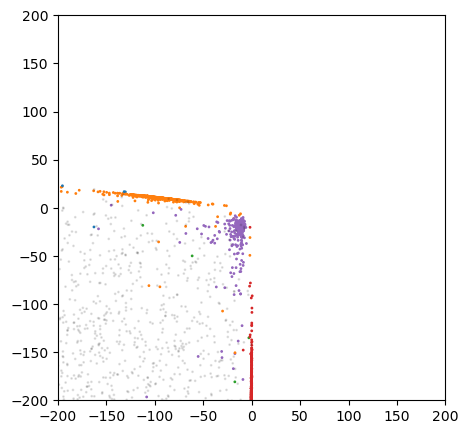

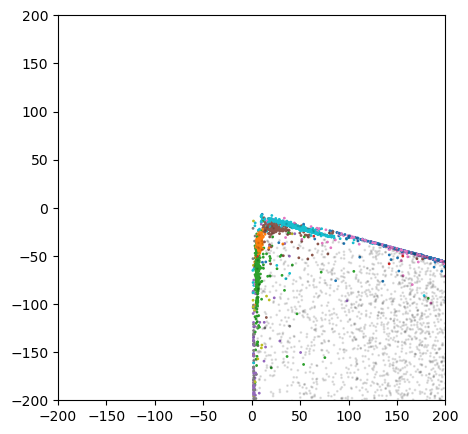

In [74]:
for i in [5,6,7]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

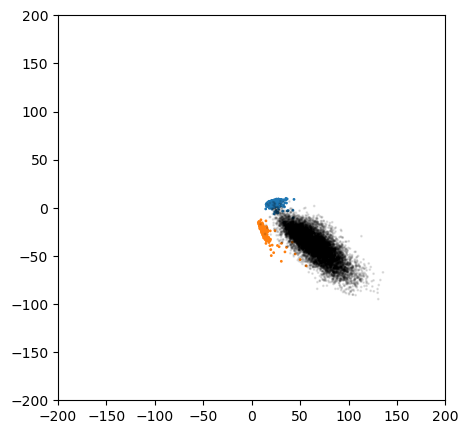

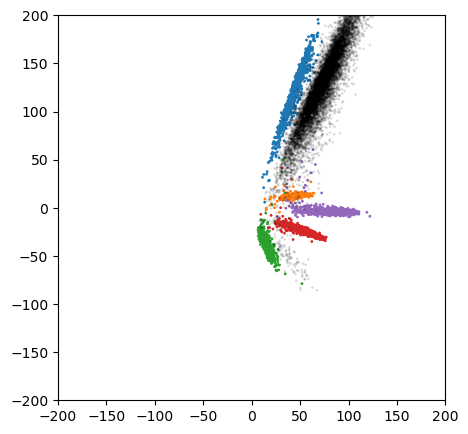

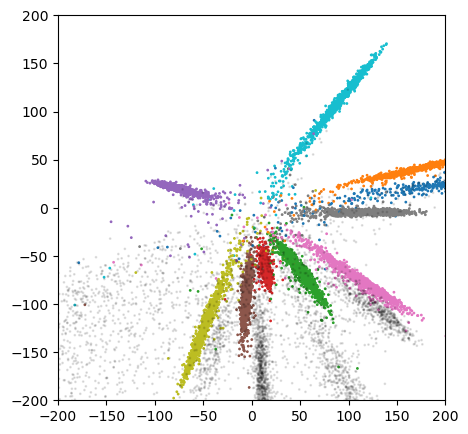

In [75]:
for i in [15,16,17]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

In [116]:
np.unique(val_gt)

array([-1,  0,  1,  2,  3])

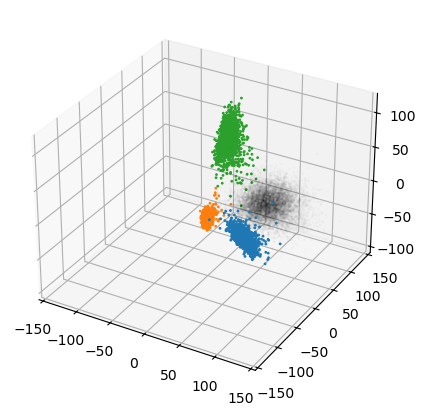

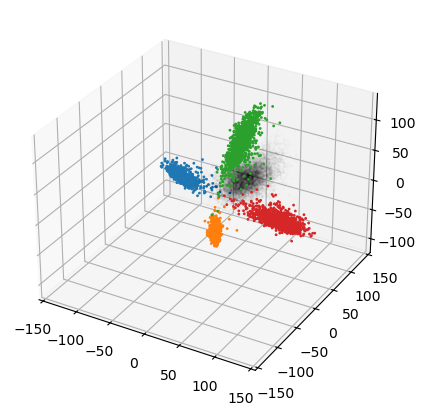

In [121]:
for i in [8,9]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))

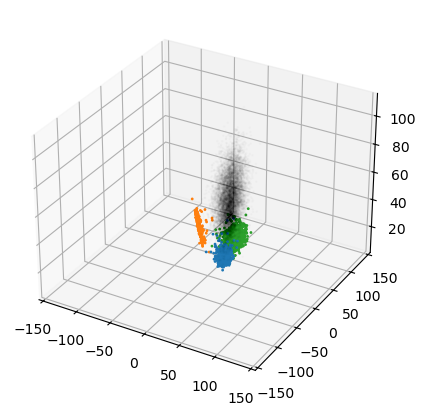

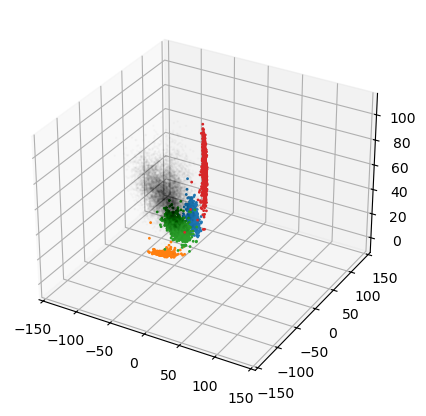

In [122]:
for i in [18,19]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))